In [21]:
import pydicom as dicom
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import scipy.ndimage
from exercises_code import *
import glob


In [22]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
"""
Define Relevant Global Variables
"""
CT_PRE_LIVER_FILES = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/2.000000-PRE LIVER-81126/*.dcm"
CT_RECON_LIVER_FILES = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/4.000000-Recon 2 LIVER 3 PHASE AP-90548/*.dcm"
CT_PHASE_LIVER_FILES = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/103.000000-LIVER 3 PHASE AP-85837/*.dcm"
SEGMENTATION_FILE = "HCC_005/01-23-1999-NA-ABDPELVIS-36548/300.000000-Segmentation-06660/1-1.dcm"


In [24]:
"""
Let's load up segmentation file since it seems easiest
"""
segmentation = dicom.dcmread(SEGMENTATION_FILE)
# flat data file does not have pixel spacing
seg_pixel = segmentation.pixel_array         # Get pixel array
print("Shape of the segmentation", seg_pixel.shape)
# pixel_array = actual data
seg_pix_arr = segmentation.pixel_array
# DICOM standard including detail information about each segment sequence
segs = segmentation.SegmentSequence
# SegmentNumber = uniquely identifies each segment within the segmentation
# SegmentLabel = which is a human-readable description or label of what each segment represents
seg_nums, seg_labels = (zip(*[(seg.SegmentNumber, seg.SegmentLabel) for seg in segs]))

Shape of the segmentation (356, 512, 512)


In [25]:
"""
Per-Frame Functional Groups Sequence
a collection of data that describes attributes or parameters that vary from one frame to another within a multi-frame image. Each item in this sequence provides metadata specific to a single frame.

details the specific characteristics of each segment as it appears in individual frames

ImagePositionPatient = Extracts the exact position of the frame relative to the standard patient coordinate system

Dimension Index Values = indices used to reference the dimensional position of the frame within the entire image dataset

Referenced Segment Number = Indicates which specific segment (identified in another part of the DICOM file) is displayed in this frame.

Source Image Sequence = Provides a reference to the original Source Image from which this frame is derived, if applicable
"""

frames = segmentation.PerFrameFunctionalGroupsSequence
"""
Generally these plane position seq, frame conttent, etc only contain 1 in the sequence. 

DICOM standards often specify that certain information should only have a single value per frame in these sequences, particularly in segmentation and other specialized imaging modalities. Thus, developers and DICOM data handlers can rely on accessing the first item ([0]) knowing that it will contain the relevant data for the frame without ambiguity or variation.

Reasons: Efficiency, Simplicity
"""
frames = segmentation.PerFrameFunctionalGroupsSequence

patient_img_pos, dim_vals, ref_seg_nums, ref_sop_iuids = (
    zip(*[
        (f.PlanePositionSequence[0].ImagePositionPatient,
         f.FrameContentSequence[0].DimensionIndexValues,
         f.SegmentIdentificationSequence[0].ReferencedSegmentNumber,
         f.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID) for f in frames
    ])
)
segmentation_df = pd.DataFrame(data={
    "ImagePositionPatient": patient_img_pos,
    "DimensionIndexValues": dim_vals,
    "ReferencedSegmentNumber": ref_seg_nums,
    "ReferencedSOPInstanceUID": ref_sop_iuids
})

print("patient position:", patient_img_pos)
print("dimension index values:", dim_vals)
print("reference segment number:", ref_seg_nums)
print("reference SOP instance uid:", ref_sop_iuids)

patient position: ([-1.963000e+02, -2.100000e+02, -2.350000e+02], [-1.963000e+02, -2.100000e+02, -2.325000e+02], [-1.963000e+02, -2.100000e+02, -2.300000e+02], [-1.963000e+02, -2.100000e+02, -2.275000e+02], [-1.963000e+02, -2.100000e+02, -2.250000e+02], [-1.963000e+02, -2.100000e+02, -2.225000e+02], [-1.963000e+02, -2.100000e+02, -2.200000e+02], [-1.963000e+02, -2.100000e+02, -2.175000e+02], [-1.963000e+02, -2.100000e+02, -2.150000e+02], [-1.963000e+02, -2.100000e+02, -2.125000e+02], [-1.963000e+02, -2.100000e+02, -2.100000e+02], [-1.963000e+02, -2.100000e+02, -2.075000e+02], [-1.963000e+02, -2.100000e+02, -2.050000e+02], [-1.963000e+02, -2.100000e+02, -2.025000e+02], [-1.963000e+02, -2.100000e+02, -2.000000e+02], [-1.963000e+02, -2.100000e+02, -1.975000e+02], [-1.963000e+02, -2.100000e+02, -1.950000e+02], [-1.963000e+02, -2.100000e+02, -1.925000e+02], [-1.963000e+02, -2.100000e+02, -1.900000e+02], [-1.963000e+02, -2.100000e+02, -1.875000e+02], [-1.963000e+02, -2.100000e+02, -1.850000e

In [26]:
# loading all dicom files
ct_dicom_files = glob.glob(CT_PHASE_LIVER_FILES)
loaded_ct_files = [dicom.dcmread(f) for f in ct_dicom_files]
ct_images = {f.SOPInstanceUID: f for f in loaded_ct_files}
print('Number of Phase Liver CT:', len(ct_images))
print(ct_images.keys())

Number of Phase Liver CT: 89
dict_keys(['1.3.6.1.4.1.14519.5.2.1.1706.8374.256856271982949194978880859241', '1.3.6.1.4.1.14519.5.2.1.1706.8374.326908718665071230950475019945', '1.3.6.1.4.1.14519.5.2.1.1706.8374.139080550644953533631381096834', '1.3.6.1.4.1.14519.5.2.1.1706.8374.546102526901955939750378151852', '1.3.6.1.4.1.14519.5.2.1.1706.8374.103896201960946229834447481410', '1.3.6.1.4.1.14519.5.2.1.1706.8374.746876633457660546228664476474', '1.3.6.1.4.1.14519.5.2.1.1706.8374.290102744870829052615109114308', '1.3.6.1.4.1.14519.5.2.1.1706.8374.159990375599301808138499397076', '1.3.6.1.4.1.14519.5.2.1.1706.8374.808448432209244110755132928077', '1.3.6.1.4.1.14519.5.2.1.1706.8374.112947859402884630337515212592', '1.3.6.1.4.1.14519.5.2.1.1706.8374.216429978104569985410711101807', '1.3.6.1.4.1.14519.5.2.1.1706.8374.259531401290950910527058518590', '1.3.6.1.4.1.14519.5.2.1.1706.8374.204486663146879804135135027290', '1.3.6.1.4.1.14519.5.2.1.1706.8374.806007742727212060624312311220', '1.3.6.1

In [27]:
# Check acquisition number is the same
print("Same patient acquisition number", all([f.AcquisitionNumber for f in loaded_ct_files]))

Same patient acquisition number True


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch


def axial_rotate_and_mip_projection(img, angle):
    return MIP_sagittal_plane(rotate_on_axial_plane(img, angle))

class PatientCTSegmentationData:
    def __init__(self, 
                 slice_number_to_data, 
                 slice_number_to_uid,
                 ct_images,
                 segmentation):
        self.slice_number_to_data = slice_number_to_data
        self.slice_number_to_uid = slice_number_to_uid
        self.block_dict = self.block_construction()
        self.ct_images = ct_images
        self.segmentation = segmentation

    def block_construction(self):
        # Determine the shape and number of slices
        # This is based on patient location now but I kept the variable name. 
        slice_numbers = sorted(self.slice_number_to_data.keys())
        num_slices = len(slice_numbers)
        sample_slice = self.slice_number_to_data[slice_numbers[0]]['ct_scan']
        height, width = sample_slice.shape
    
        ct_block = np.zeros((num_slices, height, width))
        segmentation_blocks = {}
        combined_segmentation = np.zeros((num_slices, height, width))
    
        # Find maximum segment number for segmentation block creation
        max_segment_number = max(
            max(keys for keys in data if isinstance(keys, int))
            for data in self.slice_number_to_data.values() if any(isinstance(keys, int) for keys in data)
        )
        for i in range(1, max_segment_number + 1):
            segmentation_blocks[i] = np.zeros((num_slices, height, width))
    
        # Fill blocks
        for idx, slice_number in enumerate(slice_numbers):
            data = self.slice_number_to_data[slice_number]
            ct_block[idx] = data['ct_scan']
    
            for segment_number in range(1, max_segment_number + 1):
                if segment_number in data:
                    for mask in data[segment_number]:
                        weight = 0.2 * segment_number  # Weighting by segment number
                        segmentation_blocks[segment_number][idx] += mask * weight
                        combined_segmentation[idx] += mask * weight
    
        # Return a structured dictionary
        block_dict = {'ct_scan': ct_block, 'segmentation': combined_segmentation}
        block_dict.update(segmentation_blocks)
    
        return block_dict

    def display_fused_slice(self, index, alpha=0.3):
        """
        Display a single fused slice from the patient CT and segmentation data.
        
        Args:
        - patient_data (PatientCTSegmentationData): The patient data object.
        - slice_index (int): The index of the slice to display.
        - alpha (float): Alpha value for blending segmentation with the CT image.
        """
        # Extract CT and Segmentation data for the specified slice
        ct_slice = self.block_dict['ct_scan'][index, :, :]
        segmentation_slice = self.block_dict['segmentation'][index, :, :]
        
        # Apply colormap to CT and Segmentation
        fused = visualize_alpha_fusion(ct_slice, segmentation_slice, visualize=False)
    
        fig, ax = plt.subplots()
        pixel_len_mm = [float(self.ct_images[0].SliceThickness),
                        self.ct_images[0].PixelSpacing[0],
                        self.ct_images[0].PixelSpacing[1]]
        aspect_ratio = pixel_len_mm[0] / pixel_len_mm[1]
        ax.imshow(fused)
    
        # Create a legend for the segmentation
        # Normalize the CT slice for better visibility
        norm = plt.Normalize(vmin=np.min(segmentation_slice), 
                             vmax=np.max(segmentation_slice))
        seg_norm = norm(segmentation_slice)
        unique_segments = np.unique(seg_norm)
        handles = [Patch(color=matplotlib.colormaps.get_cmap('prism')(seg), label=f'Segment {int(seg*(len(self.block_dict.keys())-2) )}')
                   for seg in unique_segments if seg != 0]  # Assuming '0' is the background and not a segment
    
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f'Fused CT and Segmentation Display for Slice {index}')
        plt.axis('off')  # Turn off axis labels
        plt.show()

    def make_animation_sagittal_mip(self, 
                                    segmentation_to_show = "segmentation",
                                    frames_per_full_rotation: int = 360,
                                    result_path: str = './all_segments_redo.gif'):
        assert segmentation_to_show in {'segmentation', 1, 2, 3, 4}, 'invalid segmentation to show!'
        segment_block = self.block_dict[segmentation_to_show]
        patient_block = self.block_dict['ct_scan']
        angles = np.linspace(0, 360*(frames_per_full_rotation-1)/frames_per_full_rotation, num=frames_per_full_rotation)
        fused_images_for_animation = []
        for idx, angle in enumerate(angles):
            sagittal_seg = axial_rotate_and_mip_projection(segment_block, angle)
            sagittal_ct = axial_rotate_and_mip_projection(patient_block, angle)
            fused_img = visualize_alpha_fusion(sagittal_ct, sagittal_seg, visualize=False)
            fused_images_for_animation.append(np.flipud(fused_img))
        fig, ax = plt.subplots()
        cm = matplotlib.colormaps.get_cmap('bone')
        pixel_len_mm = [float(self.ct_images[0].SliceThickness),
                        self.ct_images[0].PixelSpacing[0],
                        self.ct_images[0].PixelSpacing[1]]
        aspect_ratio = pixel_len_mm[0] / pixel_len_mm[1]
        animation_data = [
            [
                plt.imshow(img,
                           animated=True,
                           vmin=np.amin(patient_block),
                           vmax=np.amax(patient_block),
                           cmap=cm, aspect=aspect_ratio)
            ]
            for img in fused_images_for_animation
        ]

        all_seg_rot_gif = animation.ArtistAnimation(fig, animation_data, interval=120, blit=True)
        all_seg_rot_gif.save(result_path)

    @classmethod
    def from_files(cls, patient_files, segmentation_file):
        """
        Construct the PatientCTSegmentationData from DICOM files.
        """
        # Load segmentation file and extract per frame details
        segmentation = dicom.dcmread(segmentation_file)
        frames = segmentation.PerFrameFunctionalGroupsSequence
    
        # Load and map all patient CT slices by SOPInstanceUID and slice number
        loaded_ct_files = [dicom.dcmread(f) for f in patient_files]
        slice_number_to_data = {}
        slice_number_to_uid = {}
    
        # We assume that z of patient is the one that is changing 
        # well this is not exactly assumption, we can see if we create dataframe for it
        for f in loaded_ct_files:
            slice_number = int(f.ImagePositionPatient[2])  
            slice_number_to_data[slice_number] = {'ct_scan': f.pixel_array}
            slice_number_to_uid[slice_number] = f.SOPInstanceUID
    
        # Process segmentation data
        for index, f in enumerate(frames):
            sop_uid = f.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
            seg_num = f.SegmentIdentificationSequence[0].ReferencedSegmentNumber
            slice_pixels = segmentation.pixel_array[index]  # Access each frame's pixel data
    
            # Find the slice number corresponding to the SOP UID
            slice_number = [s for s, uid in slice_number_to_uid.items() if uid == sop_uid][0]
            if seg_num not in slice_number_to_data[slice_number]:
                slice_number_to_data[slice_number][seg_num] = []
            slice_number_to_data[slice_number][seg_num].append(slice_pixels)
    
        # Order dictionary by slice number
        slice_number_to_data = dict(sorted(slice_number_to_data.items()))
    
        return cls(slice_number_to_data, 
                   slice_number_to_uid,
                   loaded_ct_files,
                   segmentation)


In [89]:
patient_obj = PatientCTSegmentationData.from_files(
    patient_files=ct_dicom_files,
    segmentation_file=SEGMENTATION_FILE
)

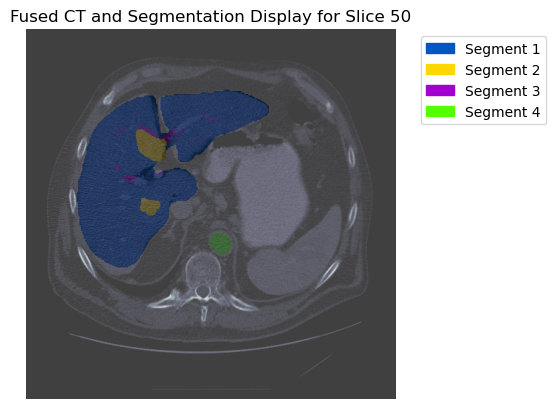

In [90]:
patient_obj.display_fused_slice(
    50
)

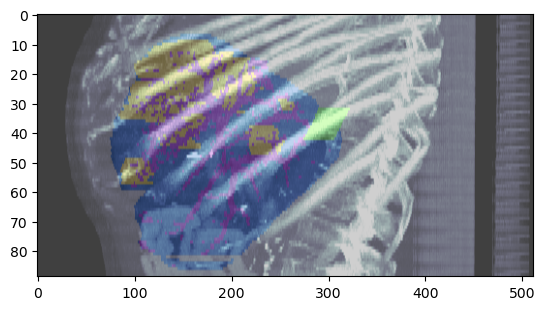

In [91]:
patient_obj.make_animation_sagittal_mip(frames_per_full_rotation=40,
                                        result_path='./all_segments_final.gif')